### Imports

In [1]:
import pandas as pd
import json
import pickle
import os, sys
from tqdm import tqdm
import numpy as np
import polars as pl
from polars import col as c
from pprint import pprint
import matplotlib.pyplot as plt
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
from sklearn.linear_model import LogisticRegression

sys.path.append("../")
pl.Config.set_tbl_rows(50)

from scripts.regex import regex_search

### constants

In [2]:
PROCESSED_COLS = []

### table creation

In [3]:
dir_path = "../data/parsed_dataframes"
file_name = "epic_records_8500.parquet"
file_path = os.path.join(dir_path, file_name)
epic_records = pd.read_parquet(file_path)

In [4]:
for column in epic_records.columns:
    epic_records[column] = epic_records[column].replace(to_replace="nan", value=np.nan)
    epic_records[column] = pd.to_numeric(epic_records[column], errors="ignore")

/var/folders/yt/5rqq39t16xs0vjb7z99vs0cw0000gn/T/ipykernel_19181/633498768.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  epic_records[column] = pd.to_numeric(epic_records[column], errors="ignore")


In [5]:
epic_records = (
    pl.from_pandas(epic_records)
    .with_columns(
        c("Дата поступления")
        .cast(pl.String)
        .str.to_datetime("%d.%m.%Y %H:%M")
        .dt.date(),
        # c("lab_date").cast(pl.String).str.to_datetime("%d.%m.%Y %H:%M").dt.date(),
    )
    .rename({"Дата поступления": "admission_datetime"})
    .drop(["birthday", "record"])
    # .head(2)
)

In [6]:
epic_records = epic_records.with_columns(
    c("gender")
    .replace(
        {
            "Мужской": 1,
            "Женский": 0,
        }
    )
    .cast(pl.Int64),
    c("gospitalisation_delivery")
    .replace(
        {
            "Плановая госпитализация": 1,
            "Доставлен бригадой скорой помощи": 0,
        }
    )
    .cast(pl.Int64),
    c("gospitalisation_type")
    .replace(
        {
            "Повторный": 1,
            "Первичный": 0,
        }
    )
    .cast(pl.Int64),
)

In [7]:
PROCESSED_COLS.append("admission_datetime")
PROCESSED_COLS.append("gender")
PROCESSED_COLS.append("patient_id")
PROCESSED_COLS.append("gospitalisation_type")
PROCESSED_COLS.append("gospitalisation_delivery")

In [8]:
epic_records.head(2)

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание
str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,date,i64,i64,str,str,str
"""75DB9BE5-92BE-432F-AA97-2CC5A5…",1,"""ОБЩЕБИОГРАФИЧЕСКИЕ СВЕДЕНИЯ Н…","""АНАМНЕЗ ИБС С 2016Г., КОГДА ПЕ…","""['Состояние: Средней тяжести',…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по Killip.""","""ИБС. Прогрессирующая стенокард…","""Гипертоническая болезнь 3 стад…","""['I50.9']""","""['I20.0']""","""['E11.8', 'I10', 'E66.9']""",2023-04-03,0,1,null,null,null
"""55218D18-4928-6138-E055-000000…",1,"""АНАМНЕЗ ЖИЗНИ:""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ ИБС С 198…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по KillipПароксизмальная…","""ИБС.Острый инфаркт миокарда пе…","""Варикозно расширенные вены пищ…","""['I48.0', 'I50.1']""","""['I21.0']""","""['B18.0', 'I85.9', 'I69.4']""",2019-01-19,0,0,"""Гипертоническая болезнь III ст…","""['I11.9']""",null


In [9]:
epic_records.shape

(8506, 21)

### create target

In [10]:
# all desease codes
(
    epic_records
    # .filter(
    #     epic_records.select("patient_id").is_duplicated(),
    # )
    .select(["main_disease_desc", "main_disease_code"])
    .with_columns(c("main_disease_code").str.slice(offset=2, length=3))[
        "main_disease_code"
    ]
    .value_counts()
    .sort(
        "count",
        descending=True,
    )
    .head()
)

main_disease_code,count
str,u32
"""I21""",4348
"""I20""",4058
"""I50""",22
"""I25""",17
"""I11""",17


In [11]:
labeled_data = (
    epic_records
    # .filter(
    #     epic_records.select("patient_id").is_duplicated(),
    # )
    .with_columns(
        c("main_disease_code").str.slice(
            offset=2,
            length=3,
        )
    )
    .group_by("patient_id")
    .agg(
        pl.all().sort_by("admission_datetime").first(),
        c("admission_datetime")
        .sort_by("admission_datetime")
        .alias("following_admission_datetimes"),
        c("main_disease_code")
        .sort_by("admission_datetime")
        .alias("following_main_disease_codes"),
    )
    .with_columns(
        c("following_admission_datetimes").list.slice(offset=1),
        c("following_main_disease_codes").list.slice(offset=1),
    )
    .with_columns(
        pl.when(c("following_main_disease_codes").list.contains("I21"))
        .then(1)
        .when(c("following_main_disease_codes").list.contains("I22"))
        .then(1)
        .when(c("following_main_disease_codes").list.len().eq(0))
        .then(-1)
        .otherwise(0)
        .alias("target")
    )
)

In [12]:
labeled_data["target"].value_counts().sort("target")
# 1 - has IM
# 0 - no IM
# -1 - no info about outcome

target,count
i32,u32
-1,6289
0,518
1,473


In [13]:
labeled_data.shape

(7280, 24)

In [14]:
PROCESSED_COLS.append("target")

### make features

#### final_table2
- useless

In [15]:
pd.DataFrame(eval(labeled_data["final_table2"].to_numpy()[0]))

,Вид нозологической единицы,Врачебное описание нозологической единицы,Код по МКБ-10
0,Основное заболевание,ИБС. Острый инфаркт миокарда без з.Q нижне-бок...,I21.4
1,Основное заболевание,ИБС. Острый инфаркт миокарда без з.Q нижне-бок...,I21.4
2,Основное заболевание,ИБС. Острый инфаркт миокарда без з.Q нижне-бок...,I21.4
3,Осложнение основного заболевания,ОСН 1 по Killip,I50.1
4,Сопутствующее заболевание,Ожирение 2 степени. (ИМТ 39 кг/м2).,E66.9


In [16]:
# same values that are already in table

#### final_table1 -> first gospitalization results
- Характер основного заболевания
- Результат обращения

In [17]:
# plt.hist
pl.from_pandas(
    pd.DataFrame(
        eval(
            labeled_data.with_columns(c("final_table1").str.len_chars().alias("fdsa"))
            .sort(["fdsa"])["final_table1"]
            .to_numpy()[241]
        )
    )
)

Характер основного заболевания,Исход госпитализации,Результат обращения,Признак подозрения на злокачественное новообразование,Признак развертывания индивидуального поста
str,str,str,str,str
"""Острое""","""None""","""Улучшение""","""Нет""","""Нет"""


In [18]:
(
    regex_search(
        regex_string=r"Признак развертывания индивидуального поста\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""Нет""",7280


In [19]:
(
    regex_search(
        regex_string=r"Признак подозрения на злокачественное новообразование\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""Нет""",7280


In [20]:
(
    regex_search(
        regex_string=r"Результат обращения\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""Улучшение""",6899
"""Летальный исход""",217
"""Без изменения""",156
"""Ухудшение""",8


In [21]:
(
    regex_search(
        regex_string=r"Исход госпитализации\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""None""",7280


In [22]:
(
    regex_search(
        regex_string=r"Характер основного заболевания\':\s{0:\s\'(\D*)\'}",
        column="final_table1",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""Острое""",7002
"""Ранее установленное хроническо…",204
"""None""",69
"""Впервые в жизни установленное …",5


In [23]:
new_columns_regex_final_table1 = {
    "main_desease_status": r"Характер основного заболевания\':\s{0:\s\'(\D*)\'}",
    "gospitalization_result": r"Результат обращения\':\s{0:\s\'(\D*)\'}",
}

In [24]:
section = "final_table1"
for column_name, regex_string in new_columns_regex_final_table1.items():
    new_column = regex_search(
        regex_string=regex_string,
        column=section,
        dataframe=labeled_data,
    )
    labeled_data = labeled_data.with_columns(
        new_column.replace({"": None}).alias(section + "_" + column_name)
    )

    PROCESSED_COLS.append(section + "_" + column_name)

#### condition
- Состояние/статус
- у доли пациентов проводили начальное обследование. можно достать рост, вес и тд

In [25]:
print(eval(labeled_data["condition"][327])[-1])

Объективный статус: 
ФИЗИКАЛЬНОЕ ИССЛЕДОВАНИЕ: 
СТЕПЕНЬ ТЯЖЕСТИ СРЕДНЕЙ ТЯЖЕСТИ СОЗНАНИЕ: ЯСНОЕ УРОВЕНЬ СОЗНАНИЯ ПО ШКАЛЕ ГЛАЗГО  15 
СОСТОЯНИЕ ПОДКОЖНО-ЖИРОВОЙ КЛЕТЧАТКИ: ТЕЛОСЛОЖЕНИЕ НОРМОСТЕНИК ПИТАНИЕ: НОРМАЛЬНОЕ 
ОЦЕНКА СОСТОЯНИЯ КОЖНЫХ ПОКРОВОВ: ФИЗИОЛОГИЧЕСКОЙ ОКРАСКИ, НОРМАЛЬНОЙ ВЛАЖНОСТИ ОЦЕНКА СОСТОЯНИЯ ВИДИМЫХ СЛИЗИСТЫХ ОБОЛОЧЕК: БЕЗ ПАТОЛОГИЧЕСКИХ ВЫСЫПАНИЙ ЗЕВ ЧИСТЫЙ, НЕ ГИПЕРЕМИРОВАН ЯЗЫК ВЛАЖНЫЙ ЧИСТЫЙ
ОТЕКИ: ОТСУТСТВУЮТ 
ЛИМФОУЗЛЫ ПРИ ПАЛЬПАЦИИ: НЕ УВЕЛИЧЕНЫ, НЕ ПАЛЬПИРУЮТСЯ 
ОЦЕНКА КОСТНО-МЫШЕЧНОЙ СИСТЕМЫ: БЕЗ ПАТОЛОГИЧЕСКИХ ИЗМЕНЕНИЙ; НИЖНИЕ КОНЕЧНОСТИ: ФИЗИОЛОГИЧЕСКОЙ ОКРАСКИ  НЕ ГИПЕРЕМИРОВАНЫ ОБЕ НИЖНИЕ КОНЕЧНОСТИ НА ОЩУПЬ ТЕПЛЫЕ ПУЛЬСАЦИЯ ОТЧЕТЛИВАЯ ПРИ ПАЛЬПАЦИИ БЕЗБОЛЕЗНЕННЫ 
РЕЗУЛЬТАТЫ ПЕРКУССИИ И АУСКУЛЬТАЦИИ ЛЕГКИХ:  ДЫХАНИЕ: ВЕЗИКУЛЯРНОЕ  ХРИПЫ: НЕ ВЫСЛУШИВАЮТСЯ  ПЕРКУССИЯ ЛЕГКИХ: ПРИ СРАВНИТЕЛЬНОЙ ПЕРКУССИИ ЛЕГКИЙ НАД ВСЕЙ ПОВЕРХНОСТЬЮ ЛЕГОЧНЫХ ПОЛЕЙ ОПРЕДЕЛЯЕТСЯ ЯСНЫЙ ЛЕГОЧНЫЙ ЗВУК. 
РЕЗУЛЬТАТЫ ПЕРКУССИИ И АУСКУЛЬТАЦИИ СЕРДЦА:  ОБЛАСТЬ СЕРДЦА И КРУПНЫХ СОС

In [204]:
for i in range(70):
    if "стентирование ка".upper() in labeled_data["full_wards"][i]:
        print(i)

17
18
20
27
29
37
40
42
43
44
47
49
50
52
62
66
69


In [196]:
labeled_data["full_wards"][10]

'{\'Сведения о пребывании пациента в Приемное отделение\': {\'Компьютерная томография ангиография грудного отдела аорты (16.10.2023 14:00)\': {\'{urn:hl7-org:v3}table\': {\'{urn:hl7-org:v3}col\': [{\'width\': \'12%\'}, {\'width\': \'88%\'}], \'{urn:hl7-org:v3}tbody\': {\'{urn:hl7-org:v3}tr\': [{\'{urn:hl7-org:v3}td\': [{\'{urn:hl7-org:v3}content\': {\'text\': \'Эффективная доза\'}}, {\'{urn:hl7-org:v3}content\': {}}]}, {\'{urn:hl7-org:v3}td\': [{\'{urn:hl7-org:v3}content\': {\'text\': \'Протокол\'}}, {\'{urn:hl7-org:v3}content\': {\'text\': \'ПРИ КТ-ИССЛЕДОВАНИИ ГРУДНОГО ОТДЕЛА АОРТЫ С КОНТРАСТНЫМ УСИЛЕНИЕМ:\\nКОНТУРЫ АОРТЫ РОВНЫЕ, ЧЕТКИЕ, ПРОСВЕТ КОНТРАСТИРОВАН, С ПРИСТЕНОЧНЫМИ ГЕТЕРОГЕННЫМИ АТЕРОМАТОЗНЫМИ НАЛОЖЕНИЯМИ В ДИСТАЛЬНОЙ ДУГЕ И НИСХОДЯЩЕМ ОТДЕЛЕ. ВОСХОДЯЩИЙ ОТДЕЛ ВЕРЕТЕНООБРАЗНО РАСШИРЕН.\\nАОРТАЛЬНЫЙ КЛАПАН - ТРЕХСТВОРЧАТЫЙ.\\nЛОКАЛЬНЫХ НАДРЫВОВ ИНТИМЫ, ИНТРАМУРАЛЬНЫХ ГЕМАТОМ, ПЕНЕТРИРУЮЩИХ ЯЗВ НЕ ОТМЕЧАЕТСЯ.\\n\\nДИАМЕТР ГРУДНОГО ОТДЕЛА АОРТЫ:\\nФИБРОЗНОЕ КОЛЬЦО АОРТАЛЬНОГ

In [125]:
result = {}

In [215]:
find_str = "killip"
z = (
    regex_search(
        regex_string=rf"(...........{find_str}........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    # .head(10)
)
z

new_column,count
str,u32
"""""",3591
"""\nосн i по killip. (i50.1""",718
"""\nосн 1 по killip. (i50.1""",514
""": осн i по killip. (i50.1""",293
"""е:\nосн по killip i (i50.""",285
"""\nосн i по killip. (i50.9""",218
""": осн 1 по killip. (i50.1""",202
"""\nосн i по killip (i50.1)""",200
""": осн i по killip (i50.1)""",113


In [216]:
z[1]["new_column"].item()

'\\nосн i по killip. (i50.1'

In [229]:
killip_class_list = []
for i in labeled_data["full_wards"].to_list():
    killip_class_list.append(extract_killip_class(i))

In [231]:
set(killip_class_list)

{1, 2, 3, 4}

In [244]:
import re


def extract_killip_class(text):
    """
    Extracts Killip class (I, II, III, IV, 1, 2, 3, 4) from a string,
    allowing the class to appear before or after the word 'KILLIP'.
    Returns the class as an integer (1-4) or None if not found.
    """
    text = text.upper().replace("І", "I")  # handle cyrillic I

    # Patterns: class before or after 'KILLIP'
    patterns = [
        r"([IV]{1,3}|[1-4]).{0,5}KILLIP",  # class before KILLIP
        r"KILLIP[^\w]{0,5}([IV]{1,3}|[1-4])",  # class after KILLIP
    ]
    roman_to_int = {"I": 1, "II": 2, "III": 3, "IV": 4}
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            val = match.group(1)
            if val in roman_to_int:
                return roman_to_int[val]
            try:
                return int(val)
            except ValueError:
                return None
    return None


# Example usage:
examples = [
    "\\nосн i по killip. (i50.1",
    "\\nосн 1 по killip. (i50.1",
    ": осн i по killip. (i50.1",
    "е:\\nосн по killip i (i50.",
    "\\nосн i по killip. (i50.9",
    ": осн 1 по killip. (i50.1",
    "\\nосн i по killip (i50.1)",
    ": осн i по killip (i50.1)",
    "е:\\nосн по killip 1. (i50",
    "ие: осн по killip i (i50.",
    ": осн i по killip. (i50.9",
    " стадия по killip (i50.1)",
    "е:\\nосн по killip 1 (i50.",
    "\\nосн 1 по killip (i50.1)",
    "\\nосн 1 по killip. (i50.0",
    "nосн iv по killip. кардио",
    " осн iv по killip. кардио",
    "ложнение:\\nkillip i (i50.",
    "nосн ii по killip. (i50.1",
    "осн iii по killip. отек л",
    "\\nocн i по killip. (i50.1",
    ": осн 1 по killip (i50.1)",
    "ие: осн по killip 1. (i50",
    "е:\\nосн по killip i. (i50",
    ": осн i по killip. гиперт",
    ": ocн i по killip. (i50.1",
    "\\nосн i по killip (i50.9)",
    "nосн iv по killip (кардио",
    " стадия по killip. (i50.1",
    "\\nосн i по killip. ранняя",
    ": осн 1 по killip. (i50.0",
    ": осн 1 по killip. гиперт",
    "осн iii по killip (отёк л",
    "ение:\\nосн killip 1 (i50.",
    "ия: осн по killip i. гипе",
    ". осн i по killip. ожирен",
    "\\nосн 1 по killip (i50.0)",
    "сложнение: killip i (i50.",
    " осн iv по killip (кардио",
    "ие: осн по killip i. (i50",
    "\\nосн 1 по killip. ранняя",
    ": осн i по killip.(i50.1)",
    "ие: осн по killip 1 (i50.",
    ": осн 1 по killip (i50.9)",
    "\\nосн i по killip (i50.0)",
    " осн ii по killip. (i50.1",
    "осн iii по killip, отек л",
    ": осн i по killip. ранняя",
    "ие:\\nосн i killip (i50.1)",
    "- осн 1 по killip.(i50.1)",
    ": осн i по killip (i50.9)",
    ": осн i по killip (i50.0)",
    "\\nосн i по killip на фоне",
    "nосн ii по killip. (i50.9",
    ") осн 1 по killip. (i50.1",
    ": осн i по killip. сахарн",
    "ение:\\nосн killip i (i50.",
    "\\nосн 1 по killip (i50.9)",
    ": осн 4 по killip. кардио",
    "\\nосн i по killip. аневри",
    "е:\\nосн по killip iii отё",
    ": осн 1 по killip(i50.1) ",
    ": осн 1 по killip (i50.0)",
    ": осн 1 по killip на фоне",
    "е:осн i по killip. (i50.1",
    ": осн 1 по killip.(i50.1)",
    "\\nосн 4 по killip. кардио",
    "- осн i по killip.(i50.1)",
    "\\nосн 1 по killip на фоне",
    "nосн iv по killip. отек л",
    ": осн i по killip(i50.1) ",
    "ия: осн по killip 1. гипе",
    "\\nосн 1 по killip, на фон",
    "\\nосн i по killip. (i50.0",
    "осн iii по killip. (i50.1",
    "е:\\nосн 1 (killip). (i50.",
    "ние: осн i killip (i50.1)",
    "\\nосн 1 по killip. двусто",
    "осн iii по killip (отек л",
    " 4. осн по killip i. атер",
    " осн iv по killip. (i50.1",
    ". осн 1 по killip. (i50.1",
    " осн ii по killip (i50.1)",
    "ия: осн по killip 1. саха",
    "е:\\nосн по killip 1. ранн",
    "nосн ii по killip. на фон",
    "- осн i по killip(i50.1)\\",
    ")\\n осн по killip 1.(i50.",
    "\\n\\nосн по killip i (i50.",
    ". осн i по killip. перене",
    "\\nосн i по killip. тромб ",
    "\\nосн i по killip. фибрил",
    ": осн 2 по killip. (i50.1",
    "осн iii по killip.отек ле",
    "осн iii по killip. отёк л",
    " стадия по killip. гиперт",
    ": осн 1 по killip.(i50.0)",
    ": осн i по killip. пблнпг",
    " стадия по killip (кардио",
    ": осн 1 по killip. ранняя",
    "nосн ii по killip (i50.1)",
    ". осн i по killip. остеох",
    "\\nосн i по killip. парокс",
    "ия: осн по killip 4. кард",
    ") осн i по killip. (i50.9",
    ": осн 1 по killip. частая",
    "\\nосн 3 по killip. отек л",
    "nосн ii по killip, на фон",
    "ие: осн 1 (killip). (i50.",
    "нение: осн killip 1 (i50.",
    "ложнение:\\nkillip i. ранн",
    "ни, риск 4 killip i. сд 2",
    ": осн i по killip. синусо",
    "ия: осн по killip i гипер",
    "1 осн 1 по killip гиперте",
    "nосн iv по killip (i50.0)",
    "ложнение:\\nkillip i. пблн",
    "\\nосн 1 по killip.ранняя ",
    "я.осн i по killip.облитер",
    "ие: осн по killip ii. дву",
    ": \\nосн по killip i (i50.",
    "\\nосн i по killip.(i50.9)",
    "осн iii по killip (i50.9)",
    ": осн i по killip. ишемич",
    "\\nосн i по killip.хсн iib",
    ": осн i по killip. фибрил",
    "\\nосн 1 по killip. неболь",
    "е:\\nосн по killip i. паро",
    "е:\\nосн по killip 3. отек",
    "\\n\\nосн по killip 1 (i50.",
    ": осн i по killip. остано",
    "нение: осн killip i (i50.",
    "\\nосн 1 по killip. парокс",
    ". осн i по killip \\nперен",
    "ение:\\nосн killip 0 (i50.",
    " 4. осн по killip i. нрс.",
    "\\nосн i по killip. фж, эи",
    "го: осн по killip 4. кард",
    "\\nосн 2 по killip. (i50.1",
    ") осн i по killip. (i50.1",
    "е:\\nосн по killip i. тром",
    "е:\\nосн по killip i. ранн",
    ": осн 1 по killip. двусто",
    "\\nосн i по killip. фж от ",
    ". осн i по killip. язвенн",
    "ложнение:\\nkillip ii (i50",
    "ложнение:\\nkillip ii на ф",
    "nосн ii по killip. ранняя",
    " 4. осн по killip i. ожир",
    ": осн i по killip. апикал",
    ". осн i по killip. атерос",
    "ложнение:\\nkillip iii (от",
    "основного: killip i(i50.1",
    "я.осн 1 по killip. ранняя",
    "ие: осн по killip ii на ф",
    "го: осн по killip i.(i50.",
    ": осн i по killip. язвенн",
    "ие: осн по killip i. уста",
    ": осн i по killip. парокс",
    "осн iii по killip. на фон",
    "ия: осн по killip i. саха",
    ".4) осн по killip i (i50.",
    "\\nосн i по killip. на фон",
    ": осн i по killip. (i50.0",
    " осн iv по killip.кардиог",
    "е:\\nосн по killip ii. дву",
    "\\nосн 4 по killip. желудо",
    ") осн 1 по killip (i50.1)",
    ": осн 1 по killip. полная",
    ". осн 1 по killip на фоне",
    " осн ii по killip. атерос",
    " 4. осн по killip i. дэп ",
    "е:\\nосн по killip ii. уст",
    "ие: осн по killip iii. от",
    "е:осн i по killip (i50.9)",
    "\\nосн i по killip.парокси",
    "ия. осн по killip i (i50.",
    ": осн i по killip. вторич",
    " осн iv по killip. остано",
    "\\nосн i по killip. острый",
    ").\\nосн по killip iv. кар",
    " осн iv по killip. клинич",
    ": осн i по killip. фж от ",
    "nосн iv по killip. (i50.1",
    " стадия по killip. парокс",
    ": осн i по killip.(i50.9)",
    ": осн i по killip(i50.1)\\",
    "осн iii по killip (i50.1)",
    "nосн iv по killip.парокси",
    "\\nосн 1 по killip. гидрот",
    "е:\\nосн по killip 1 гемоп",
    ": осн i по killip. гидрот",
    ": осн 1 по killip. вторич",
    "осн iii по killip. интерс",
    " (i44.2) \\nkillip i (i50.",
    "ложнение:\\nkillip iv. оте",
    " осн iv по killip. отёк л",
    "е:осн i по killip. (i50.9",
    "n осн 1 по killip (i50.1)",
    ": осн i по killip. отёк л",
    "сновного - killip i(i50.1",
    "г.осн 1 по killip на фоне",
    "е:\\nосн по killip i на фо",
    "0)\\nосн по killip iv. аси",
    "    осн по killip i (i50.",
    " осн ii по killip.(i50.1)",
    "е:\\nосн по killip i . (i5",
    ": осн 1 по killip.вторичн",
    " осн iv по killip. отек л",
    "nосн ii по killip. двухст",
    "\\nосн 1 по killip. (i50.9",
    "nосн ii по killip. (i50.0",
    ") осн 3 по killip. отек л",
    "сложнение: killip iii (i5",
    ". осн i по killip. парокс",
    "ложнение:\\nkillip iv. кар",
    "\\nосн 2 по killip. сердеч",
    "е:\\nосн по killip i. хсн ",
    "ии (i49.3) killip ii (i50",
    " стадия по killip на фоне",
    ": осн i по killip. c-r ле",
    "n осн i по killip. (i50.1",
    ".2) осн по killip 1. (i50",
    " 4. осн по killip i ожире",
    "\\nосн 1 по killip(i50.1) ",
    "е:\\nосн по killip i. вабк",
    "nосн iv по killip. слр.фи",
    " стадия по killip ожирени",
    " г. осн по killip i. ранн",
    ": осн i по killip. ожирен",
    " стадии по killip (i50.1)",
    " 4. осн по killip i\\nпере",
    ". осн i по killip стеноз ",
    ": осн i по killip. полная",
    "\\nосн i по killip. хсн ii",
    " осн iv по killip, угнете",
    "ложнение:\\nkillip i. пере",
    " стадия по killip. фибрил",
    ": ocн i по killip (i50.1)",
    ": осн i по killip. тромб ",
    "ие: осн по killip 3. отек",
    ". осн 1 по killip. атерос",
    "степени по killip (i50.1)",
    ". осн 3 по killip. гиперт",
    "осн iii по killip отек ле",
    "е:\\nосн по killip i. прех",
    " стадия по killip. ожирен",
    " осн iv по killip кардиог",
    "\\nосн i по killip. раняя ",
    ". осн i по killip. хронич",
    "\\nосн i по killip. двусто",
    "5%. осн по killip i хрони",
    "ие:\\nосн i killip (i50.9)",
    "ложнение:\\nkillip iii (i5",
    "\\nосн i по killip.\\nгипер",
    ": осн i по killip. дилата",
    "nосн ii по killip. ишемич",
    " %. осн по killip 1. атер",
    "\\nосн i по killip. остано",
    "е:\\nосн по killip 4. кард",
    ": осн 1 по killip. раняя ",
    "\\nосн 1 по killip. \\nсопу",
]

for ex in examples:
    print(ex, "->", extract_killip_class(ex))

\nосн i по killip. (i50.1 -> 1
\nосн 1 по killip. (i50.1 -> 1
: осн i по killip. (i50.1 -> 1
е:\nосн по killip i (i50. -> 1
\nосн i по killip. (i50.9 -> 1
: осн 1 по killip. (i50.1 -> 1
\nосн i по killip (i50.1) -> 1
: осн i по killip (i50.1) -> 1
е:\nосн по killip 1. (i50 -> 1
ие: осн по killip i (i50. -> 1
: осн i по killip. (i50.9 -> 1
 стадия по killip (i50.1) -> 1
е:\nосн по killip 1 (i50. -> 1
\nосн 1 по killip (i50.1) -> 1
\nосн 1 по killip. (i50.0 -> 1
nосн iv по killip. кардио -> 4
 осн iv по killip. кардио -> 4
ложнение:\nkillip i (i50. -> 1
nосн ii по killip. (i50.1 -> 2
осн iii по killip. отек л -> 3
\nocн i по killip. (i50.1 -> 1
: осн 1 по killip (i50.1) -> 1
ие: осн по killip 1. (i50 -> 1
е:\nосн по killip i. (i50 -> 1
: осн i по killip. гиперт -> 1
: ocн i по killip. (i50.1 -> 1
\nосн i по killip (i50.9) -> 1
nосн iv по killip (кардио -> 4
 стадия по killip. (i50.1 -> 1
\nосн i по killip. ранняя -> 1
: осн 1 по killip. (i50.0 -> 1
: осн 1 по killip. гиперт -> 1
осн iii 

In [245]:
# z["new_column"].to_list()[1:]

In [257]:
find_str = "[^\w]st[^\w]"
z = (
    regex_search(
        regex_string=rf"(..........{find_str}.............)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)
z

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/var/folders/yt/5rqq39t16xs0vjb7z99vs0cw0000gn/T/ipykernel_19181/3480805845.py:1: SyntaxWarning: invalid escape sequence '\w'
  find_str = "[^\w]st[^\w]"


new_column,count
str,u32
"""""",3236
"""я сегмента st в ii, iii, av""",87
"""я сегмента st в отведениях """,81
"""я сегмента st общей продолж""",67
"""менений с. st не зарегистри""",60
"""я сегмента st в ii, iii avf""",48
""" изменения st-t не зарегист""",43
"""и сегмента st не выявлено.\""",34
"""я сегмента st в отв. ii, ii""",28


In [258]:
z[1]["new_column"].item()

'я сегмента st в ii, iii, av'

In [176]:
result[find_str] = z.filter(c("new_column") == "")["count"].item() / 7200
result

{'тропонин': 0.7551388888888889,
 'st ': 0.4766666666666667,
 'killip': 0.49875,
 'grace': 0.9863888888888889}

In [116]:
(
    regex_search(
        regex_string=r"(...АД.........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",7280


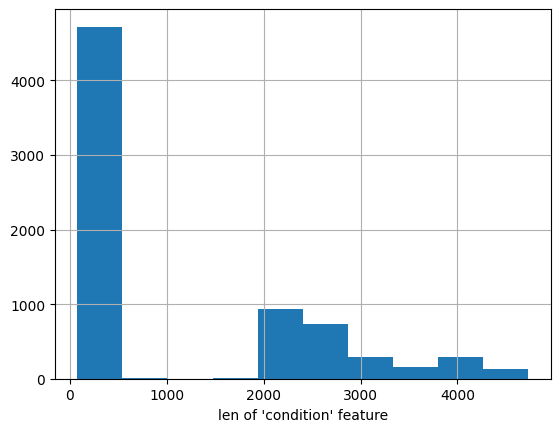

In [26]:
plt.hist(
    labeled_data.with_columns(c("condition").str.len_chars().alias("fdsa"))
    .sort(["fdsa"])["fdsa"]
    .to_numpy()
    # [140]
)
plt.xlabel("len of 'condition' feature")
plt.grid()

In [27]:
(
    regex_search(
        regex_string=r"(АРТЕРИАЛЬНОЕ ДАВЛЕНИЕ)",
        column="condition",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",5436
"""АРТЕРИАЛЬНОЕ ДАВЛЕНИЕ""",1844


In [28]:
(
    regex_search(
        regex_string=r"НАСЫЩЕНИЕ КРОВИ КИСЛОРОДОМ \(САТУРАЦИЯ, %\)\D*(\d+)",
        column="condition",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(5)
)

new_column,count
str,u32
"""""",5570
"""98""",864
"""97""",276
"""96""",201
"""99""",135


In [29]:
new_columns_regex_condition = {
    "oxygen_saturation": r"НАСЫЩЕНИЕ КРОВИ КИСЛОРОДОМ \(САТУРАЦИЯ, %\)\D*(\d+)",
    "bmi": r"ИМТ\D*(\d+)",
    "status": r"Состояние:\s*(.{2,24})',",
    # "left_atrium": r"ЛЕВОЕ",
}

In [30]:
section = "condition"

for column_name, regex_string in new_columns_regex_condition.items():
    new_column = regex_search(
        regex_string=regex_string,
        column=section,
        dataframe=labeled_data,
    )
    labeled_data = labeled_data.with_columns(
        new_column.replace({"": None}).alias(section + "_" + column_name)
    )

    PROCESSED_COLS.append(section + "_" + column_name)

#### full wards
- ecg
- rentgenogram
- ultrasound

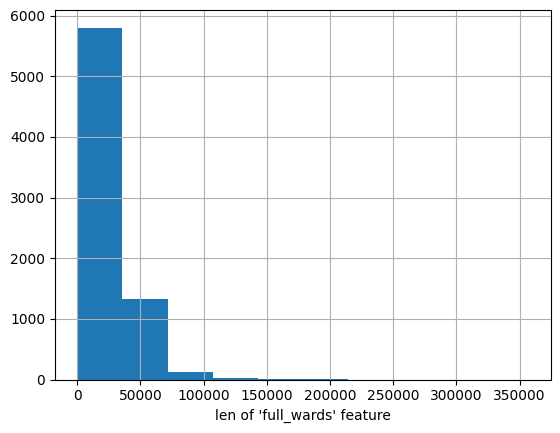

In [31]:
plt.hist(
    labeled_data.with_columns(c("full_wards").str.len_chars().alias("fdsa"))
    .sort(["fdsa"])["fdsa"]
    .to_numpy()
    # [140]
)
plt.xlabel("len of 'full_wards' feature")
plt.grid()

In [32]:
def clean_full_wards(x):
    x = x.replace("!", "")
    x = re.sub(
        r"{urn:hl7-org:v3}",
        "",
        x,
    )
    # x = re.sub(
    #     r"\'\D+\':",
    #     " ",
    #     x,
    # )
    # x = re.sub(
    #     r"[\\n{}\'\"]",
    #     " ",
    #     x,
    # )
    x = re.sub(
        r"  +",
        " ",
        x,
    )
    return x


labeled_data = labeled_data.with_columns(
    c("full_wards")
    .map_elements(
        clean_full_wards,
        return_dtype=str,
    )
    .alias("full_wards_cleaned")
)

In [33]:
labeled_data["full_wards_cleaned"][-4][:100]

"{'Сведения о пребывании пациента в Приемное отделение': {}, 'Сведения о пребывании пациента в Кардио"

In [34]:
pd.DataFrame(eval(labeled_data["full_wards_cleaned"][-4]))

,Сведения о пребывании пациента в Приемное отделение,Сведения о пребывании пациента в Кардиологическое отделение с ПРиИТ для лечения больных с ОКС (ПСО) №1,Сведения о пребывании пациента в Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №2
Электрокардиография (29.12.2023 17:00),NaN,"{'table': {'col': [{'width': '12%'}, {'width':...",NaN
Электрокардиография (27.12.2023 15:28),NaN,NaN,"{'table': {'col': [{'width': '12%'}, {'width':..."
Электрокардиография (28.12.2023 11:09),NaN,NaN,"{'table': {'col': [{'width': '12%'}, {'width':..."
Электрокардиография (28.12.2023 11:34),NaN,NaN,"{'table': {'col': [{'width': '12%'}, {'width':..."


In [35]:
# print
# (
# pd.DataFrame(eval(labeled_data["full_wards_cleaned"][-4]))
# .loc[
#     "Рентгеноскопия грудной клетки (14.02.2023 20:55)",
#     "Сведения о пребывании пациента в Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №1",
# ]
# ['table']
# ['tbody']['tr']
# [1]['td'][1]['content']['text']
# .keys()
# )

##### ECG features

In [36]:
new_columns_regex_ecg = {
    "ecg_right_atrium": r"ПРАВОЕ ПРЕДСЕРДИЕ:.*?(\d+[,.]\d+)",
    "ecg_left_atrium": r"ЛЕВОЕ ПРЕДСЕРДИЕ:.*?(\d+[,.]\d+)",
    "ecg_right_ventricle": r"ПРАВЫЙ ЖЕЛУДОЧЕК:.*?(\d+[,.]\d+)",
    "ecg_end_diastolic_volume": r"КДО:\s*(\d+)*",
    "ecg_end_systolic_volume": r"КСО:\s*(\d+)*",
    "ecg_stroke_volume": r"УО:\s*(\d+)*",
    "ecg_ejection_fraction": r"ФВ:\s*(\d+[-.,]\d+|\d+)*",
    "ecg_ventricular_septal": r"МЖП:\s*(\d+[,.]\d+)",
    "ecg_e_a": r"Е/А\s*(\d+[,.]\d+)",
    "ecg_aorta_diameter_valsalva_sinuses": r"ДИАМЕТР АО НА УРОВНЕ СИНУСОВ ВАЛЬСАЛЬВЫ:\s*(\d+[,.]\d+)",
    "ecg_ascending_aorta": r"ВОСХОДЯЩАЯ АОРТА:\s*(\d+[,.]\d+)",
    "ecg_aortic_arch": r"ДУГА АОРТЫ.\s*(\d+[,.]\d+)",
    "ecg_sinus_heart_rate": r"СИНУСОВЫЙ.{0,7}ЧСС\s*(\d+[,.]\d+)",
    "ecg_age": r"ДАТА РОЖДЕНИЯ\):\s(\d{2}) ",
    "ecg_heart_rate": r"ЧСС\s*[-,:РАВЕН]*\s*(\d{2,4})",
    "ecg_bmi": r"ИМТ\D*(\d+)",
    # "left_atrium": r"ЛЕВОЕ",
}

In [37]:
section = "full_wards"
for column_name, regex_string in new_columns_regex_ecg.items():
    new_column = regex_search(
        regex_string=regex_string,
        column=section,
        dataframe=labeled_data,
    )
    labeled_data = labeled_data.with_columns(
        new_column.replace({"": None}).alias(section + "_" + column_name)
    )

    PROCESSED_COLS.append(section + "_" + column_name)

##### potential features

In [38]:
(
    regex_search(
        regex_string=r"(ЭЛЕВАЦИЯ.{0,7}СЕГМЕНТА..........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",6080
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В ОТВ.""",167
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В II, """,150
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В ОТВЕ""",101
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST ОБЩЕЙ """,73
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В V1-V""",71
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST В III,""",47
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST, ПАТОЛ""",32
"""ЭЛЕВАЦИЯ СЕГМЕНТА ST И ВЫСО""",27


In [39]:
(
    regex_search(
        regex_string=r"(РЕПОЛЯРИЗАЦИ..........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",3377
"""РЕПОЛЯРИЗАЦИИ НИЖНЕЙ С""",514
"""РЕПОЛЯРИЗАЦИИ ПЕРЕДНЕ-""",501
"""РЕПОЛЯРИЗАЦИИ БОКОВОЙ """,395
"""РЕПОЛЯРИЗАЦИИ НИЖНЕ-БО""",275
"""РЕПОЛЯРИЗАЦИИ ПЕРЕДНЕ """,243
"""РЕПОЛЯРИЗАЦИИ ВЕРХУШЕЧ""",228
"""РЕПОЛЯРИЗАЦИИ НИЖНЕЙ, """,152
"""РЕПОЛЯРИЗАЦИИ МИОКАРДА""",137


In [40]:
(
    regex_search(
        regex_string=r"(ТИЧЕСКАЯ БЛЯШКА..........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",3712
"""ТИЧЕСКАЯ БЛЯШКА В УСТЬЕ """,672
"""ТИЧЕСКАЯ БЛЯШКА В УСТЬЕ""",562
"""ТИЧЕСКАЯ БЛЯШКА В БИФУРКА""",395
"""ТИЧЕСКАЯ БЛЯШКА В БИФУР""",257
"""ТИЧЕСКАЯ БЛЯШКА В БИФУРК""",235
"""ТИЧЕСКАЯ БЛЯШКА, СТЕНОЗИР""",216
"""ТИЧЕСКАЯ БЛЯШКА В БАССЕЙН""",156
"""ТИЧЕСКАЯ БЛЯШКА ПО ЗАДНЕ""",121


In [41]:
(
    regex_search(
        regex_string=r"(ТЕНЬ СЕРДЦА..........)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",7113
"""ТЕНЬ СЕРДЦА РАСШИРЕНА""",57
"""ТЕНЬ СЕРДЦА НЕЗНАЧИТЕ""",42
"""ТЕНЬ СЕРДЦА ВИЗУАЛЬНО""",19
"""ТЕНЬ СЕРДЦА НЕ РАСШИР""",14
"""ТЕНЬ СЕРДЦА УМЕРЕННО """,8
"""ТЕНЬ СЕРДЦА ОБЫЧНОЙ К""",6
"""ТЕНЬ СЕРДЦА ЗНАЧИТЕЛЬ""",5
"""ТЕНЬ СЕРДЦА ПРОЕКЦИОН""",3


In [42]:
(
    regex_search(
        regex_string=r"(АОРТА ................)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""АОРТА СМ. \nАОРТАЛЬНЫЙ""",2657
"""АОРТА НЕ РАСШИРЕНА, КО""",918
"""АОРТА НЕ РАСШИРЕНА.\nК""",892
"""""",779
"""АОРТА СМ. АОРТАЛЬНЫЙ К""",352
"""АОРТА ЧЕТКО НЕ ДИФФЕРЕ""",266
"""АОРТА С РОВНЫМ ЧЕТКИМ """,258
"""АОРТА ЧАСТИЧНО ДИФФЕРЕ""",201
"""АОРТА НЕ РАСШИРЕНА.КУП""",88


In [43]:
(
    regex_search(
        regex_string=r"(..............ГИДРОТОРАКС.......)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",6300
"""ЛЕВОСТОРОННИЙ ГИДРОТОРАКС.'}}]…",76
"""КТИКА/РЕГРЕСС ГИДРОТОРАКСА, НО…",38
"""ЕВОСТОРОННЕГО ГИДРОТОРАКСА.'}}…",37
""" ДВУСТОРОННИЙ ГИДРОТОРАКС.'}}]…",32
"""ДВУСТОРОННЕГО ГИДРОТОРАКСА.'}}…",20
"""2-Х СТОРОННИЙ ГИДРОТОРАКС.'}}]…",17
"""ЕВОСТОРОННЕГО ГИДРОТОРАКСА, СО…",16
"""АВОСТОРОННЕГО ГИДРОТОРАКСА.'}}…",14


In [44]:
(
    regex_search(
        regex_string=r"(..СЕРДЦЕ..............)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""\nСЕРДЦЕ НЕ РАСШИРЕНО.""",2010
"""""",1265
"""\nСЕРДЦЕ ПРОЕКЦИОННО Р""",685
"""\nСЕРДЦЕ ОБЫЧНО РАСПОЛ""",523
"""\nСЕРДЦЕ ОБЫЧНОЙ КОНФИ""",454
"""\nСЕРДЦЕ И КРУПНЫЕ СОС""",416
"""\nСЕРДЦЕ ВИЗУАЛЬНО НЕ """,189
"""\nСЕРДЦЕ РАСШИРЕНО.\nА""",180
"""\nСЕРДЦЕ НЕ РАСШИРЕНО,""",171


In [45]:
# (
#     pd.DataFrame(eval(labeled_data["full_wards"][3])).loc[
#         "Электрокардиография (25.09.2022 01:15)",
#         "Сведения о пребывании пациента в Приемное отделение",
#     ]
# )

In [46]:
print(
    "Ф.И.О.: М В М\nВОЗРАСТ (ДАТА РОЖДЕНИЯ): 73 ( 01.01.1698!) \nПРЕДВАРИТЕЛЬНЫЙ ДИАГНОЗ: ИБС. ИНФАРКТ МИОКАРДА НИЖНЕ-ЗАДНЕЙ СТЕНКИ С ПОДЪЕМОМ СЕГМЕНТА ST ОТ 21.07.2022. КОРОНАРНАЯ БАЛОННАЯ АНГИОПЛАСТИКА СО СТЕНТИРОВАНИЕМ ПР/3 - СР/3 ОВ КАЛИПСО 4,0 X 33 MM (KL33400) ОТ 21.07.2022\nРЕЗУЛЬТАТЫ ОБСЛЕДОВАНИЯ:\nПРАВОЕ ПРЕДСЕРДИЕ:  3,6 СМ.; \tПРАВЫЙ ЖЕЛУДОЧЕК: 3,0 СМ.; \nЛЕВОЕ ПРЕДСЕРДИЕ: 4,3 СМ.; В ДЛИНУ: 5,3СМ.; ОБЪЕМ 67 МЛ. S ЛП 21,1 СМ2 \nЛЕВЫЙ ЖЕЛУДОЧЕК: КДО: 125 МЛ.; КСО: 70 МЛ.; УО:  55  МЛ.; ФВ: 45 % \nМЖП: 1,5 СМ ; НЕОПРЕДЕЛЕННЫЙ ТИП ДВИЖЕНИЯ \nЗАДНЯЯ СТЕНКА: 1,15 СМ.; УМЕРЕННЫЙ ГИПОКИНЕЗ\nНИЖНЯЯ СТЕНКА УМЕРЕННЫЙ ГИПОКИНЕЗ\nМИТРАЛЬНЫЙ КЛАПАН: СТВОРКИ НЕ УПЛОТНЕНЫ, ПРОТИВОФАЗА СОХРАНЕНА \n\tРСМК - СМ.;\tФК В ДИАСТОЛУ - СМ.;\nМИТРАЛЬНОЕ ОТВЕРСТИЕ: СМ2.; Д - СМ2\nГРАДИЕНТ ДАВЛЕНИЯ ПИК: 1,8 ММ. РТ. СТ. СРЕДНИЙ: ММ. РТ. СТ.\nСКОРОСТЬ КРОВОТОКА: 0,7 М/С.; СТЕПЕНЬ РЕГУРГИТАЦИИ: ДО 2 (25% ОТ S ЛП), ЦЕНТРАЛЬНАЯ СТРУЯ, V.C 0,5 СМ, S РЕГ. СТРУИ 5,4 СМ2 \nЕ/А 0,7 DT МС. \nАОРТА: СТЕНКИ УПЛОТНЕНЫ, АМПЛИТУДА ИХ ДВИЖЕНИЯ СОХРАНЕНА \nФИБРОЗНОЕ КОЛЬЦО: 2.1 СМ.;  УПЛОТНЕНО, ЕДИНИЧНЫЙ КАЛЬЦИНАТ;\nДИАМЕТР АО НА УРОВНЕ СИНУСОВ ВАЛЬСАЛЬВЫ: 3,5 СМ. ВОСХОДЯЩАЯ АОРТА: 3,6 СМ..;\nДУГА АОРТЫ  СМ ПЕРЕШЕЕК    ММ.РТ.СТ. НИСХОДЯЩАЯ АОРТА СМ. \nАОРТАЛЬНЫЙ КЛАПАН: СТВОРКИ УПЛОТНЕНЫ ОТКРЫТИЕ 2,0СМ. \nГРАДИЕНТ ДАВЛЕНИЯ ПИК: 5.4 ММ. РТ. СТ.; СРЕДНИЙ: ММ. РТ. СТ.\nСКОРОСТЬ КРОВОТОКА: 1,1М/С. СТЕПЕНЬ РЕГУРГИТАЦИИ: ; S РЕГ. СТРУИ СМ2 \nТРИКУСПИДАЛЬНЫЙ КЛАПАН: ИНТАКТНЫЙ \nГРАДИЕНТ ДАВЛЕНИЯ ПИК: ММ. РТ. СТ.; СРЕДНИЙ: ММ. РТ. СТ.\nСКОРОСТЬ КРОВОТОКА: М/С. СТЕПЕНЬ РЕГУРГИТАЦИИ:1\nЛЕГОЧНАЯ АРТЕРИЯ: ФК 2,6 СМ, СТВОЛ: СМ, ПРАВАЯ ВЕТВЬ СМ, ЛЕВАЯ: СМ.\nГРАДИЕНТ ДАВЛЕНИЯ ПИК: 2,8 ММ. РТ. СТ.; СРЕДНИЙ: ММ. РТ. СТ.\nСКОРОСТЬ КРОВОТОКА: 0.8 М/С.; СТЕПЕНЬ РЕГУРГИТАЦИИ: 1\nСИСТ. ДАВЛЕНИЕ В ЛЕГОЧНОЙ АРТЕРИИ: ММ. РТ. СТ. ПО ПОТОКУ TR 28 ММ. РТ. СТ.\nПЕРИКАРД: Б/О. ЧСС: УД. В МИН. \nЗАКЛЮЧЕНИЕ:\nСОСТОЯНИЕ ПОСЛЕ СТЕНТИРОВАНИЯ ОВ ОТ 21.07.22 \nУМЕРЕННЫЙ ГИПОКИНЕЗ НИЖНЕ-БАЗАЛЬНЫХ, ЗАДНЕ БАЗАЛЬНЫХ СЕГМЕНТОВ ЛЖ.\nУВЕЛИЧЕНИЕ ПОЛОСТИ ЛЕВОГО ПРЕДСЕРДИЯ. \nНЕДОСТАТОЧНОСТЬ МК ДО 2 СТ.\nГИПЕРТРОФИЯ МЖП. \nДИАСТОЛИЧЕСКАЯ ДИСФУНКЦИЯ ЛЖ I ТИП (НАРУШЕНИЕ РЕЛАКСАЦИИ ЛЖ)\nФИБРОЗ КОРНЯ И СТЕНОК ВОСХОДЯЩЕЙ АОРТЫ\nСОКРАТИТЕЛЬНАЯ ФУНКЦИЯ МИОКАРДА УМЕРЕННО СНИЖЕНА. \nДАННЫХ ЗА ЖИДКОСТЬ В ПОЛОСТИ ПЕРИКАРДА НЕТ."
)

Ф.И.О.: М В М
ВОЗРАСТ (ДАТА РОЖДЕНИЯ): 73 ( 01.01.1698!) 
ПРЕДВАРИТЕЛЬНЫЙ ДИАГНОЗ: ИБС. ИНФАРКТ МИОКАРДА НИЖНЕ-ЗАДНЕЙ СТЕНКИ С ПОДЪЕМОМ СЕГМЕНТА ST ОТ 21.07.2022. КОРОНАРНАЯ БАЛОННАЯ АНГИОПЛАСТИКА СО СТЕНТИРОВАНИЕМ ПР/3 - СР/3 ОВ КАЛИПСО 4,0 X 33 MM (KL33400) ОТ 21.07.2022
РЕЗУЛЬТАТЫ ОБСЛЕДОВАНИЯ:
ПРАВОЕ ПРЕДСЕРДИЕ:  3,6 СМ.; 	ПРАВЫЙ ЖЕЛУДОЧЕК: 3,0 СМ.; 
ЛЕВОЕ ПРЕДСЕРДИЕ: 4,3 СМ.; В ДЛИНУ: 5,3СМ.; ОБЪЕМ 67 МЛ. S ЛП 21,1 СМ2 
ЛЕВЫЙ ЖЕЛУДОЧЕК: КДО: 125 МЛ.; КСО: 70 МЛ.; УО:  55  МЛ.; ФВ: 45 % 
МЖП: 1,5 СМ ; НЕОПРЕДЕЛЕННЫЙ ТИП ДВИЖЕНИЯ 
ЗАДНЯЯ СТЕНКА: 1,15 СМ.; УМЕРЕННЫЙ ГИПОКИНЕЗ
НИЖНЯЯ СТЕНКА УМЕРЕННЫЙ ГИПОКИНЕЗ
МИТРАЛЬНЫЙ КЛАПАН: СТВОРКИ НЕ УПЛОТНЕНЫ, ПРОТИВОФАЗА СОХРАНЕНА 
	РСМК - СМ.;	ФК В ДИАСТОЛУ - СМ.;
МИТРАЛЬНОЕ ОТВЕРСТИЕ: СМ2.; Д - СМ2
ГРАДИЕНТ ДАВЛЕНИЯ ПИК: 1,8 ММ. РТ. СТ. СРЕДНИЙ: ММ. РТ. СТ.
СКОРОСТЬ КРОВОТОКА: 0,7 М/С.; СТЕПЕНЬ РЕГУРГИТАЦИИ: ДО 2 (25% ОТ S ЛП), ЦЕНТРАЛЬНАЯ СТРУЯ, V.C 0,5 СМ, S РЕГ. СТРУИ 5,4 СМ2 
Е/А 0,7 DT МС. 
АОРТА: СТЕНКИ УПЛОТНЕНЫ, АМПЛИТУДА ИХ ДВИЖЕНИЯ

In [67]:
(
    regex_search(
        regex_string=r"(томограф)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",5852
"""томограф""",1428


In [71]:
(
    regex_search(
        regex_string=r"(illip)",
        column="full_wards",
        dataframe=labeled_data,
    )
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

new_column,count
str,u32
"""""",7280


#### ward_table
useless -> drop col

In [48]:
pd.DataFrame(eval(labeled_data["ward_table"].to_numpy()[920]))

,Название,Дата поступления,Дата перевода,Профиль койки,Лечащий врач
0,Приемное отделение,19.03.2022 08:40,19.03.2022 08:49,!!!!!!!!!!!!! !!!!!!!!!!!!! ! (Врач-кардиолог),None
1,Кардиологическое отделение с ПРиИТ для лечения...,19.03.2022 08:50,19.03.2022 09:34,!!!!!!!!!!!!! !!!!!!!!!!!!! ! (Врач-кардиолог),None
2,Отделение анестезиологии-реанимации с палатами...,19.03.2022 09:35,21.03.2022 09:19,!!!!!!!!!!!!! !!!!!!!!!!!!! ! (Заведующий (нач...,None
3,Кардиологическое отделение с ПРиИТ для лечения...,21.03.2022 09:20,29.03.2022 11:00,!!!!!!!!!!!!! !!!!!!!!!!!!! ! (Врач-кардиолог),None


In [49]:
pd.DataFrame(eval(labeled_data["ward_table"].to_numpy()[920].replace("!", "")))

,Название,Дата поступления,Дата перевода,Профиль койки,Лечащий врач
0,Приемное отделение,19.03.2022 08:40,19.03.2022 08:49,(Врач-кардиолог),None
1,Кардиологическое отделение с ПРиИТ для лечения...,19.03.2022 08:50,19.03.2022 09:34,(Врач-кардиолог),None
2,Отделение анестезиологии-реанимации с палатами...,19.03.2022 09:35,21.03.2022 09:19,(Заведующий (начальник) структурного подраз...,None
3,Кардиологическое отделение с ПРиИТ для лечения...,21.03.2022 09:20,29.03.2022 11:00,(Врач-кардиолог),None


In [50]:
# empty field
d = list(
    map(
        lambda x: set(
            pd.DataFrame(eval(x.replace("!", "")))["Лечащий врач"].values.tolist()
        ),
        labeled_data["ward_table"].to_numpy(),
    )
)
set().union(*d)

{'None'}

In [51]:
def search_condition(x):

    found = re.sub(
        r", \'Лечащий врач\':.*\'None\'}",
        "",
        x.replace("!", ""),
    )
    found = re.sub(
        " +",
        " ",
        found,
    )

    return found


labeled_data = labeled_data.with_columns(
    c("ward_table").map_elements(
        search_condition,
        return_dtype=str,
    )
    # .alias("condition_status")
)
eval(labeled_data["ward_table"].to_numpy()[0])

{'Название': {0: 'Приемное отделение',
  1: 'Кардиологическое отделение с ПРиИТ для лечения больных с ОКС (ПСО) №1',
  2: 'Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №2',
  3: 'Кардиологическое отделение с ПРиИТ для лечения больных с ОКС (ПСО) №1'},
 'Дата поступления': {0: '30.07.2024 12:45',
  1: '30.07.2024 13:40',
  2: '30.07.2024 22:07',
  3: '31.07.2024 20:01'},
 'Дата перевода': {0: '30.07.2024 13:39',
  1: '30.07.2024 22:06',
  2: '31.07.2024 20:00',
  3: '07.08.2024 11:00'},
 'Профиль койки': {0: ' (Врач-кардиолог)',
  1: ' (Врач-кардиолог)',
  2: ' (Заведующий (начальник) структурного подразделения (отдела, отделения, лаборатории, кабинета, отряда и другое) медицинской организации - врач-специалист, специалист)',
  3: ' (Врач-кардиолог)'}}

In [52]:
# labeled_data = labeled_data.drop("ward_table")

#### main disease code

In [53]:
labeled_data["main_disease_code"].value_counts().sort(
    "count",
    descending=True,
).head(15)

main_disease_code,count
str,u32
"""I21""",3818
"""I20""",3388
"""I50""",17
"""I11""",13
"""I25""",8
"""I48""",8
"""I47""",7
null,3
"""I44""",3


In [54]:
labeled_data["main_disease_code"].head()

main_disease_code
str
"""I20"""
"""I21"""
"""I20"""
"""I21"""
"""I20"""
"""I21"""
"""I20"""
"""I21"""
"""I21"""


In [56]:
labeled_data.head()

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание,following_admission_datetimes,following_main_disease_codes,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_oxygen_saturation,condition_bmi,condition_status,full_wards_cleaned,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_e_a,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_aortic_arch,full_wards_ecg_sinus_heart_rate,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_ecg_bmi
str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,date,i64,i64,str,str,str,list[date],list[str],i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""971b8f4d-bfdd-4355-824d-397576…",1,"""ЭПИДЕМИОЛОГИЧЕСКИЙ АНАМНЕЗ: СО…","""ПОВЫШЕНИЕ АД ОТРИЦАЕТ. АД НЕ …","""['Состояние: Средней тяжести',…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН 1 по Killip""","""ИБС. Впервые возникшая стенока…","""Ожирение 2 степени. (ИМТ 39 кг…","""['I50.1']""","""I20""","""['E66.9']""",2024-07-30,0,1,null,null,null,[],[],-1,"""Острое""","""Улучшение""","""98""","""39""","""Средней тяжести""","""{'Сведения о пребывании пациен…","""3,6""","""4,2""","""2,9""","""127""","""53""",null,"""63""","""1,3""",null,"""3,0""","""3,3""",null,null,"""56""","""60""",null
"""4E3FC73C-F6E4-4FFF-B319-814ABF…",1,"""ЭПИДЕМИОЛОГИЧЕСКИЙ АНАМНЕЗ:СО …","""СЧИТАЕТ СЕБЯ БОЛЬНЫМ В ТЕЧЕНИЕ…","""['Состояние: Средней тяжести',…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН 1 по Killip""","""ИБС. Острый инфаркт миокарда п…","""Ожирение 1 степени. (ИМТ 30 кг…","""['I50.1']""","""I21""","""['E66.9']""",2023-10-25,0,0,"""Гипертоническая болезнь 3 стад…","""['I11.9']""",null,[],[],-1,"""Острое""","""Улучшение""","""96""",null,"""Средней тяжести""","""{'Сведения о пребывании пациен…","""4,1""","""4,3""","""2,9""","""118""","""49""","""69""","""58""",null,null,"""3,5""","""3,7""","""3,5""",null,"""59""","""64""",null
"""74D01BAC-6C96-4901-82C3-C464F5…",1,"""ЭПИДЕМИОЛОГИЧЕСКИЙ АНАМНЕЗ: СО…","""СЧИТАЕТ СЕБЯ БОЛЬНЫМ С АПРЕЛЯ …","""['Состояние: Тяжелое', 'Жалобы…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I Killip.""","""ИБС. Прогрессируюшая стенокард…","""Атеросклероз БЦС, гемодинамиче…","""['I50.0']""","""I20""","""['I70.2', 'I70.8', 'S68.1']""",2024-08-21,0,1,"""Гипертоническая болезнь III ст…","""['I11.9']""",null,[],[],-1,"""Острое""","""Улучшение""","""99""","""22""","""Тяжелое""","""{'Сведения о пребывании пациен…","""3,2""","""3,7""","""3,7""","""96""","""37""","""59""",null,null,null,"""3,6""","""3,1""","""2,7""",null,"""58""","""60""",null
"""be4b7242-b39a-4dbe-9e17-d205f3…",0,"""АНАМНЕЗ ЖИЗНИ:""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ ПОВЫШЕНИЕ…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по Killip""","""Острый субэндокардиальный инфа…","""АИТ, медикаментозный эутиреоз""","""['I50.1']""","""I21""","""['E03.8']""",2021-02-17,0,1,"""Гипертоническая болезнь III ст…","""['I11.9']""",null,[],[],-1,"""Острое""","""Улучшение""",null,null,"""

In [64]:
labeled_data.group_by("main_disease_I21").agg(
    # c("atherosclerosis").sum(),
    # c("atherosclerosis").count().alias("erfwd"),
    c("disease_I70").sum().alias("athero"),
    # c("full_wards_ecg_bmi").mean().alias("bmi"),
    # c("obesity").sum().alias("obesity"),
)

main_disease_I21,athero
i32,u32
0,1139
1,556
null,0


In [58]:
labeled_data.with_columns(
    ((c("main_disease_code") == "I21") * 1).alias("main_disease_I21"),
    ((c("main_disease_code") == "I20") * 1).alias("main_disease_I20"),
)["main_disease_I21"].head()

main_disease_I21
i32
0
1
0
1
0
1
0
1
1


In [59]:
labeled_data = labeled_data.with_columns(
    ((c("main_disease_code") == "I21") * 1).alias("main_disease_I21"),
    ((c("main_disease_code") == "I20") * 1).alias("main_disease_I20"),
)

PROCESSED_COLS.append("main_disease_I21")
PROCESSED_COLS.append("main_disease_I20")

#### secondary, background, competing, complication - disease_codes

In [60]:
labeled_data = (
    labeled_data.with_columns(
        c("secondary_disease_code").map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        ),
        c("background_disease_code").map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        ),
        c("complication_of_main_disease_code").map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        ),
        c("Конкурирующее заболевание")
        .map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        )
        .alias("competing_disease_code"),
    )
    .with_columns(
        c("secondary_disease_code").fill_null([]),
        c("background_disease_code").fill_null([]),
        c("complication_of_main_disease_code").fill_null([]),
        c("competing_disease_code").fill_null([]),
    )
    .with_columns(
        # (c("secondary_disease_code").list + c("background_disease_code").list).alias("secondary_and_background_disease_codes")
        pl.concat_list(
            c("secondary_disease_code"),
            c("background_disease_code"),
            c("complication_of_main_disease_code"),
            c("competing_disease_code"),
        ).alias("secondary_and_background_disease_codes")
    )
)

labeled_data = labeled_data.with_columns(
    c("secondary_and_background_disease_codes")
    .list.eval(pl.element().str.slice(0, 3))
    .alias("secondary_and_background_disease_codes")
)

labeled_data.select(
    "secondary_disease_code",
    "background_disease_code",
    "complication_of_main_disease_code",
    "secondary_and_background_disease_codes",
).head()

secondary_disease_code,background_disease_code,complication_of_main_disease_code,secondary_and_background_disease_codes
list[str],list[str],list[str],list[str]
"[""E66.9""]",[],"[""I50.1""]","[""E66"", ""I50""]"
"[""E66.9""]","[""I11.9""]","[""I50.1""]","[""E66"", ""I11"", ""I50""]"
"[""I70.2"", ""I70.8"", ""S68.1""]","[""I11.9""]","[""I50.0""]","[""I70"", ""I70"", … ""I50""]"
"[""E03.8""]","[""I11.9""]","[""I50.1""]","[""E03"", ""I11"", ""I50""]"
[],"[""I11.9""]","[""I50.1""]","[""I11"", ""I50""]"


In [61]:
column = labeled_data["secondary_and_background_disease_codes"].to_list()
flat_list = []

for disease_list in column:
    if disease_list is not None:
        for code in disease_list:
            flat_list.append(code[:3])
disease_codes = list(set(flat_list))

In [62]:
for disease_code in disease_codes:
    new_column = labeled_data["secondary_and_background_disease_codes"].list.contains(
        disease_code
    )

    labeled_data = labeled_data.with_columns(
        new_column.alias("disease_" + disease_code)
    )

In [63]:
disease_codes_stats = labeled_data.select(
    [f"disease_{disease_code}" for disease_code in disease_codes]
).sum()
disease_codes_stats

disease_R32,disease_T06,disease_S90,disease_G56,disease_N29,disease_Y52,disease_I10,disease_F31,disease_K45,disease_I87,disease_D61,disease_I74,disease_L95,disease_D86,disease_M05,disease_F10,disease_H26,disease_N14,disease_I26,disease_C53,disease_G30,disease_M54,disease_G20,disease_G63,disease_E61,disease_L30,disease_K27,disease_I82,disease_N85,disease_G31,disease_I41,disease_D47,disease_C81,disease_N63,disease_B37,disease_H44,disease_I83,…,disease_G50,disease_M23,disease_R15,disease_L20,disease_R56,disease_T29,disease_S98,disease_J06,disease_J42,disease_G09,disease_M42,disease_R65,disease_F03,disease_I66,disease_J02,disease_N04,disease_J33,disease_E04,disease_N03,disease_K55,disease_S01,disease_A46,disease_F32,disease_G93,disease_A16,disease_C79,disease_J67,disease_D25,disease_E21,disease_G40,disease_S06,disease_E89,disease_I08,disease_E74,disease_C46,disease_N28,disease_M48
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1,1,1,4,1,1,12,1,1,10,2,8,1,7,7,2,8,3,28,5,1,2,13,13,1,1,2,4,1,2,1,3,7,1,3,1,191,…,1,1,1,2,2,1,1,10,63,1,209,1,4,1,1,1,1,125,2,2,1,2,1,47,5,1,1,1,1,15,2,10,7,30,1,59,1


In [59]:
# drop cols where diseases are met fewer than 30 times

cols = [
    col for col in disease_codes_stats.columns if (disease_codes_stats[col] < 30).item()
]
disease_cols_to_keep = list(set(disease_codes_stats.columns) - set(cols))
labeled_data = labeled_data.drop(cols)

PROCESSED_COLS.extend(disease_cols_to_keep)

### see data

In [60]:
labeled_data.head(3)

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание,following_admission_datetimes,following_main_disease_codes,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_oxygen_saturation,condition_bmi,condition_status,full_wards_cleaned,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,…,disease_K29,disease_I49,disease_B18,disease_D64,disease_I71,disease_K26,disease_K80,disease_M10,disease_K25,disease_E06,disease_I45,disease_J45,disease_N28,disease_L40,disease_N18,disease_I69,disease_I63,disease_H90,disease_I70,disease_E66,disease_I11,disease_D50,disease_C50,disease_C34,disease_G93,disease_I64,disease_E03,disease_J42,disease_J44,disease_C18,disease_I34,disease_K86,disease_M42,disease_I83,disease_E10,disease_U07,disease_I25
str,i64,str,str,str,str,str,str,str,str,str,str,list[str],str,list[str],date,i64,i64,str,list[str],str,list[date],list[str],i32,str,str,str,str,str,str,str,str,str,str,str,str,str,…,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
"""520F7224-F8A3-13FE-E055-000000…",1,"""Б""","""СЧИТАЕТ СЕБЯ БОЛЬНЫМ С 10.11.2…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по Killip""","""ИБС. Впервые возникшая стенока…","""Пароксизмальная форма фибрилля…","[""I50.1""]","""I20""","[""E11.8"", ""I48.0""]",2022-11-17,0,0,"""Гипертоническая болезнь III ст…","[""I11.9""]",null,[],[],-1,"""Ранее установленное хроническо…","""Улучшение""",null,"""27""","""Удовлетворительное""","""{'Сведения о пребывании пациен…","""3,4""","""4,5""","""3,0""","""97""","""35""","""62""","""64""",…,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
"""121147A3-665C-46B3-BBFB-B18060…",1,"""АНАМНЕЗ ЖИЗНИ:""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ КОРОНАРНОГ…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН по Killip I""","""ИБС.Острый инфаркт миокарда пе…","""Рак левого лёгкого""","[""I50.1""]","""I21""","[""C34.9""]",2021-03-26,0,0,"""Гипертоническая болезнь III ст…","[""I11.9""]",null,[],[],-1,"""Ранее установленное хроническо…","""Улучшение""",null,null,"""Удовлетворительное""","""{'Сведения о пребывании пациен…","""3,6""","""4,0""","""2,8""","""133""","""60""","""74""","""55""",…,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false
"""60A9D420-4628-4631-BB0A-B2F8AD…",1,"""Б""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ НАСТОЯЩЕЕ…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН по Killip 1""","""ОКС с подъемом сегмента ST.""","""Ожирение 1 степени (ИМТ 33 кг…","[""I50.1""]","""I21""","[""E66.9""]",2022-06-01,0,1,"""Гипертоническая болезнь III ст…","[""I11.9""]",null,"[2022-06-22, 2022-07-13]","[""I20"", ""I20""]",0,"""Острое""","""Улучшение""",null,null,"""Удовлетворительное""","""{

In [61]:
len(PROCESSED_COLS)

78

In [62]:
# useful_cols = (
#     [
#         "patient_id",
#         "gender",
#         "target",
#         "main_disease_I21",
#         "main_disease_I20",
#         "gospitalisation_type",
#         "gospitalisation_delivery",
#         "admission_datetime",
#         "following_admission_datetimes",
#     ]
#     + disease_cols_to_keep
#     + ["final_table1_" + col for col in new_columns_regex_final_table1.keys()]
#     + ["condition_" + col for col in new_columns_regex_condition.keys()]
#     + ["full_wards_" + col for col in new_columns_regex_ecg.keys()]
# )

# # # labeled_data.select(useful_cols).head()

### clean and convert to dtypes

In [63]:
labeled_data.select(PROCESSED_COLS).null_count()

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_oxygen_saturation,condition_bmi,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_e_a,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_aortic_arch,full_wards_ecg_sinus_heart_rate,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_ecg_bmi,main_disease_I21,main_disease_I20,disease_K29,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,…,disease_N40,disease_E06,disease_E66,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,disease_C34,disease_I34,disease_I25,disease_I63,disease_E03,disease_K80,disease_E74,disease_E10,disease_L40,disease_I50,disease_H90,disease_M42,disease_D64,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,5570,4994,0,338,341,337,458,420,576,622,1103,4250,502,901,3629,7279,68,354,4319,3,3,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
(
    labeled_data.filter(
        c("target") != -1,
    )
    .select(PROCESSED_COLS)
    .null_count()
    # .shape
)

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_oxygen_saturation,condition_bmi,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_e_a,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_aortic_arch,full_wards_ecg_sinus_heart_rate,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_ecg_bmi,main_disease_I21,main_disease_I20,disease_K29,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,…,disease_N40,disease_E06,disease_E66,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,disease_C34,disease_I34,disease_I25,disease_I63,disease_E03,disease_K80,disease_E74,disease_E10,disease_L40,disease_I50,disease_H90,disease_M42,disease_D64,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,825,753,0,30,29,30,48,44,62,74,133,569,46,110,509,991,6,36,565,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
(
    labeled_data.with_columns(
        pl.coalesce([c("full_wards_ecg_bmi"), c("condition_bmi")]).alias("bmi")
    ).select(
        "condition_bmi",
        "full_wards_ecg_bmi",
        "bmi",
    )
    # .shape
    .null_count()
)

condition_bmi,full_wards_ecg_bmi,bmi
u32,u32,u32
4994,4319,3069


In [66]:
labeled_data = labeled_data.with_columns(
    pl.coalesce([c("full_wards_ecg_bmi"), c("condition_bmi")])
    .cast(pl.Float64)
    .alias("bmi")
)

In [67]:
PROCESSED_COLS.append("bmi")
PROCESSED_COLS.pop(PROCESSED_COLS.index("condition_bmi"))
PROCESSED_COLS.pop(PROCESSED_COLS.index("full_wards_ecg_bmi"))
PROCESSED_COLS.pop(PROCESSED_COLS.index("condition_oxygen_saturation"))
PROCESSED_COLS.pop(PROCESSED_COLS.index("full_wards_ecg_e_a"))
PROCESSED_COLS.pop(PROCESSED_COLS.index("full_wards_ecg_aortic_arch"))
PROCESSED_COLS.pop(PROCESSED_COLS.index("full_wards_ecg_sinus_heart_rate"))

'full_wards_ecg_sinus_heart_rate'

In [68]:
labeled_data = labeled_data.with_columns(
    c("full_wards_ecg_ejection_fraction")
    .str.slice(-2)
    .str.replace(",", ".")
    .cast(pl.Float64)
)

In [69]:
labeled_data = labeled_data.with_columns(
    c("full_wards_ecg_ascending_aorta")
    .str.slice(-2)
    .replace(".", None)
    .str.replace(",", ".")
    .cast(pl.Float64)
)

In [70]:
(
    labeled_data.select(
        "full_wards_ecg_right_atrium",
        "full_wards_ecg_left_atrium",
        "full_wards_ecg_right_ventricle",
        "full_wards_ecg_end_diastolic_volume",
        "full_wards_ecg_end_systolic_volume",
        "full_wards_ecg_stroke_volume",
        "full_wards_ecg_ventricular_septal",
        "full_wards_ecg_aorta_diameter_valsalva_sinuses",
        "full_wards_ecg_ascending_aorta",
        "full_wards_ecg_age",
        "full_wards_ecg_heart_rate",
        "bmi",
    )
    #
    .head()
    # .null_count()
)

full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,bmi
str,str,str,str,str,str,str,str,f64,str,str,f64
"""3,4""","""4,5""","""3,0""","""97""","""35""","""62""","""1,5""","""3,7""",0.6,"""66""","""48""",26.0
"""3,6""","""4,0""","""2,8""","""133""","""60""","""74""",null,"""4,4""",0.1,"""69""","""60""",20.0
"""3,8""","""4,0""","""2,7""","""126""","""58""","""68""","""2,0""","""3,5""",0.7,"""72""","""68""",33.0
"""3,1""","""3,2""","""2,6""","""77""","""27""","""49""","""1,0""","""3,1""",0.3,"""53""","""72""",22.0
"""4,1""","""3,6""","""4,0""","""98""","""54""","""44""","""1,3""","""3,4""",0.8,"""64""","""59""",null


In [71]:
cols = [
    "full_wards_ecg_right_atrium",
    "full_wards_ecg_left_atrium",
    "full_wards_ecg_right_ventricle",
    "full_wards_ecg_end_diastolic_volume",
    "full_wards_ecg_end_systolic_volume",
    "full_wards_ecg_stroke_volume",
    "full_wards_ecg_ventricular_septal",
    "full_wards_ecg_aorta_diameter_valsalva_sinuses",
    "full_wards_ecg_age",
    "full_wards_ecg_heart_rate",
    # "bmi",
]

In [72]:
for col in cols:
    labeled_data = labeled_data.with_columns(
        c(col).str.replace(",", ".").cast(pl.Float64)
    )

In [73]:
labeled_data = labeled_data.with_columns(
    c("final_table1_main_desease_status")
    .replace(
        {
            "Впервые в жизни установленное хроническое": 0,
            "Ранее установленное хроническое": 1,
            "Острое": 2,
            "None": None,
        }
    )
    .cast(pl.Int64)
)

In [74]:
labeled_data = labeled_data.with_columns(
    c("condition_status")
    .replace(
        {
            "Удовлетворительное": 0,
            "Средней тяжести": 1,
            "Тяжелое": 2,
            "Тяжелое', 'Жалобы: __": 2,
            "Крайне тяжелое": 3,
        }
    )
    .cast(pl.Int64)
)

In [75]:
labeled_data = labeled_data.with_columns(
    c("final_table1_gospitalization_result")
    .replace(
        {
            "Улучшение": 0,
            "Без изменения": 1,
            "Ухудшение": 2,
            "Летальный исход": 3,
        }
    )
    .cast(pl.Int64)
)

In [76]:
labeled_data.select(PROCESSED_COLS).head(3)

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,main_disease_I21,main_disease_I20,disease_K29,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,disease_J42,disease_N28,disease_I45,disease_I35,disease_N40,disease_E06,disease_E66,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,disease_C34,disease_I34,disease_I25,disease_I63,disease_E03,disease_K80,disease_E74,disease_E10,disease_L40,disease_I50,disease_H90,disease_M42,disease_D64,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47,bmi
date,i64,str,i64,i64,i32,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64
2022-11-17,1,"""520F7224-F8A3-13FE-E055-000000…",0,0,-1,1,0,0,3.4,4.5,3.0,97.0,35.0,62.0,64.0,1.5,3.7,0.6,66.0,48.0,0,1,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,26.0
2021-03-26,1,"""121147A3-665C-46B3-BBFB-B18060…",0,0,-1,1,0,0,3.6,4.0,2.8,133.0,60.0,74.0,55.0,null,4.4,0.1,69.0,60.0,1,0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,20.0
2022-06-01,1,"""60A9D420-4628-4631-BB0A-B2F8AD…",0,1,0,2,0,0,3.8,4.0,2.7,126.0,58.0,68.0,null,2.0,3.5,0.7,72.0,68.0,1,0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,33.0


### chech distribution of parsed cols

In [77]:
def replace_outliers_with_none(
    df: pl.DataFrame,
    cols: list[str],
    threshold: float = 3.0,
) -> pl.DataFrame:
    """
    Replaces outliers in specified columns of a Polars DataFrame with None.

    Outliers are defined as values that are more than `threshold` standard deviations
    away from the mean.

    Args:
        df: The Polars DataFrame to process.
        cols: A list of column names to check for outliers.
        threshold: The number of standard deviations from the mean to consider a value
            an outlier.  Defaults to 3.0.

    Returns:
        A new Polars DataFrame with outliers replaced by None.
    """
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        if mean is None or std is None:
            continue  # Skip if mean or std is None (e.g., all values are None)
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std

        df = df.with_columns(
            pl.when((c(col) < lower_bound) | (c(col) > upper_bound))
            .then(None)
            .otherwise(c(col))
            .alias(col)
        )
    return df


cols_to_check = [
    "full_wards_ecg_right_atrium",
    "full_wards_ecg_left_atrium",
    "full_wards_ecg_right_ventricle",
    "full_wards_ecg_end_diastolic_volume",
    "full_wards_ecg_end_systolic_volume",
    "full_wards_ecg_stroke_volume",
    "full_wards_ecg_ventricular_septal",
    "full_wards_ecg_aorta_diameter_valsalva_sinuses",
    "full_wards_ecg_age",
    "full_wards_ecg_heart_rate",
    "full_wards_ecg_ascending_aorta",
    "full_wards_ecg_ejection_fraction",
    "bmi",
]

labeled_data_filtered = replace_outliers_with_none(labeled_data, cols_to_check)

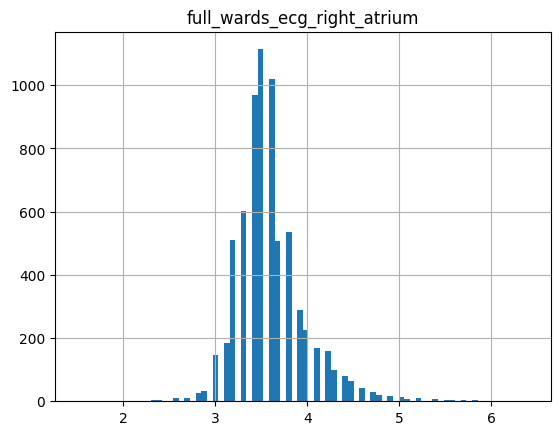

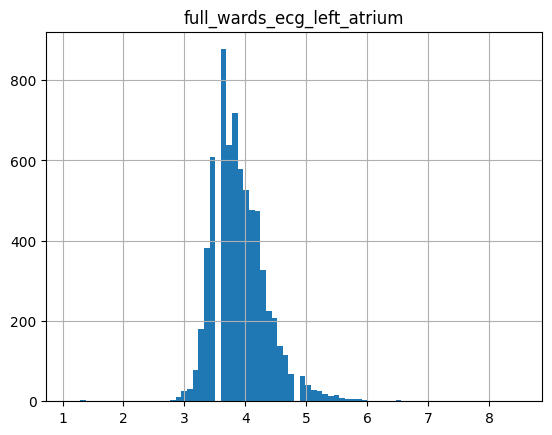

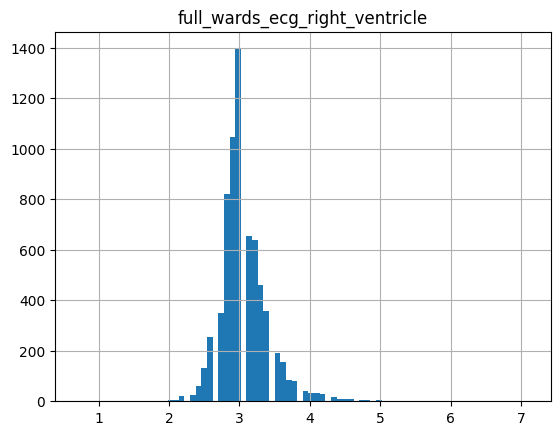

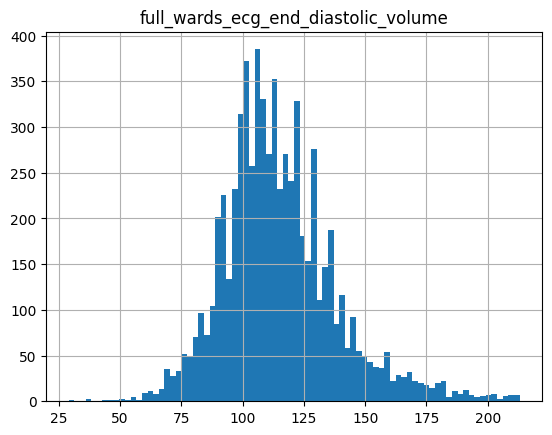

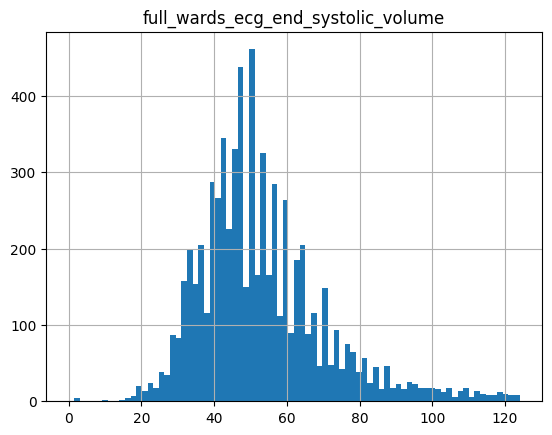

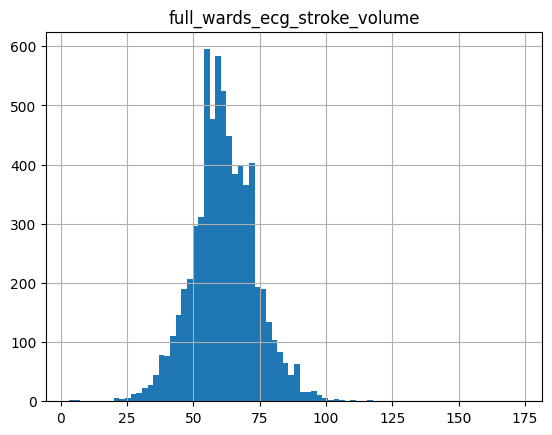

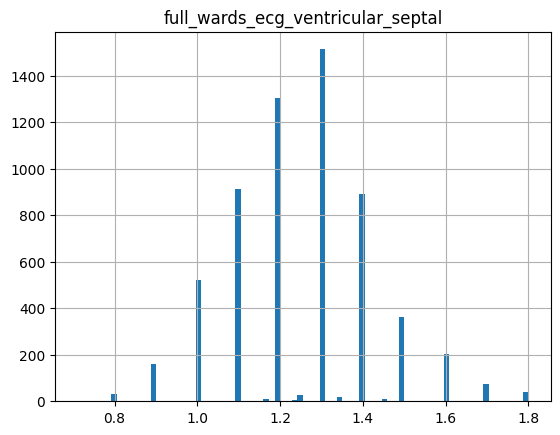

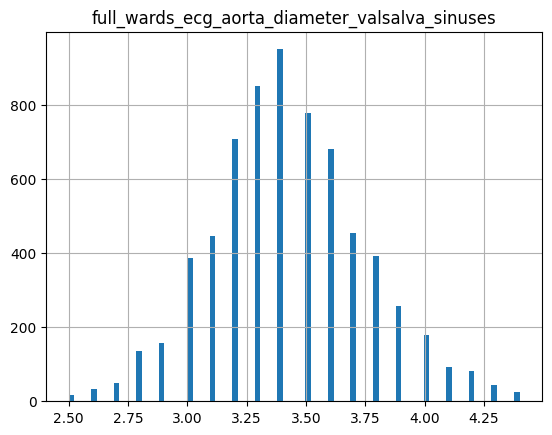

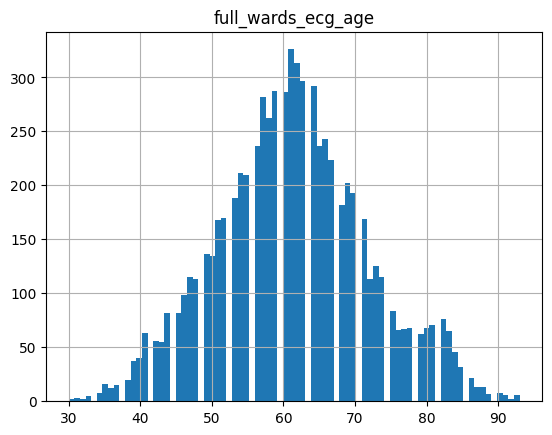

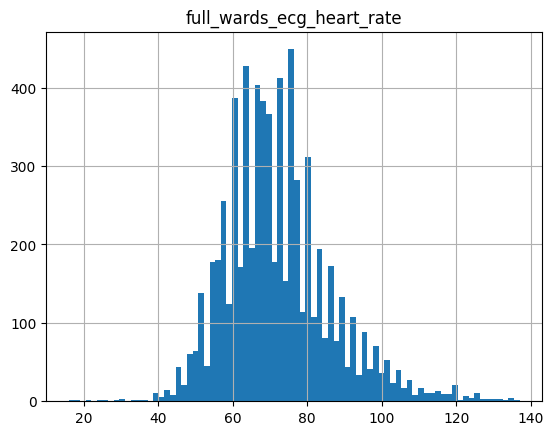

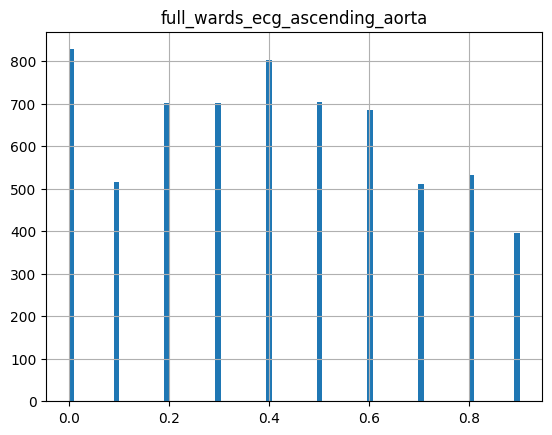

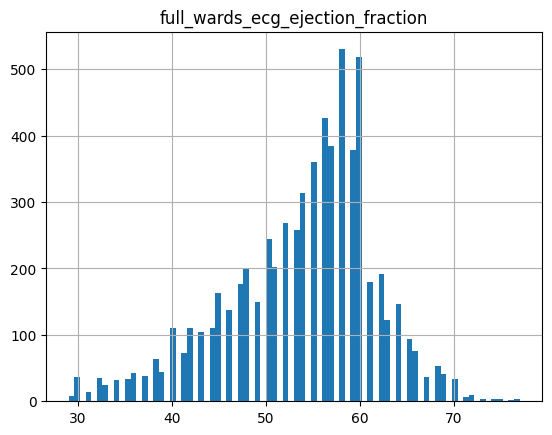

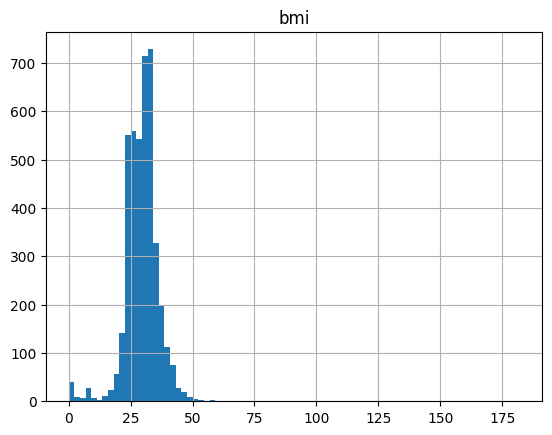

In [78]:
for col in cols_to_check:
    plt.hist(labeled_data_filtered[col], bins=80)
    plt.grid()
    plt.title(col)
    plt.show()

In [79]:
labeled_data_filtered = labeled_data_filtered.with_columns(
    pl.when(c("bmi") > 55).then(None).otherwise(c("bmi")).alias("bmi")
)

### fill missing values

In [80]:
labeled_data_filtered.select(PROCESSED_COLS).head(3)

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,main_disease_I21,main_disease_I20,disease_K29,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,disease_J42,disease_N28,disease_I45,disease_I35,disease_N40,disease_E06,disease_E66,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,disease_C34,disease_I34,disease_I25,disease_I63,disease_E03,disease_K80,disease_E74,disease_E10,disease_L40,disease_I50,disease_H90,disease_M42,disease_D64,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47,bmi
date,i64,str,i64,i64,i32,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64
2022-11-17,1,"""520F7224-F8A3-13FE-E055-000000…",0,0,-1,1,0,0,3.4,4.5,3.0,97.0,35.0,62.0,64.0,1.5,3.7,0.6,66.0,48.0,0,1,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,26.0
2021-03-26,1,"""121147A3-665C-46B3-BBFB-B18060…",0,0,-1,1,0,0,3.6,4.0,2.8,133.0,60.0,74.0,55.0,null,4.4,0.1,69.0,60.0,1,0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,20.0
2022-06-01,1,"""60A9D420-4628-4631-BB0A-B2F8AD…",0,1,0,2,0,0,3.8,4.0,2.7,126.0,58.0,68.0,null,null,3.5,0.7,72.0,68.0,1,0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,33.0


In [81]:
labeled_data_filtered.select(PROCESSED_COLS).null_count()

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,main_disease_I21,main_disease_I20,disease_K29,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,disease_J42,disease_N28,disease_I45,disease_I35,disease_N40,disease_E06,disease_E66,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,disease_C34,disease_I34,disease_I25,disease_I63,disease_E03,disease_K80,disease_E74,disease_E10,disease_L40,disease_I50,disease_H90,disease_M42,disease_D64,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47,bmi
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,69,0,0,343,347,345,535,549,578,684,1156,551,902,74,392,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3087


In [82]:
def mice_imputation_polars(df: pl.DataFrame, numerical_cols: list) -> pl.DataFrame:
    """
    Implements MICE imputation using Polars and pandas.

    Args:
        df: Polars DataFrame.
        numerical_cols: List of numerical columns to impute.

    Returns:
        Polars DataFrame with imputed values.
    """
    # Convert Polars DataFrame to pandas DataFrame
    df_pd = df.to_pandas()

    # Initialize IterativeImputer
    imputer = IterativeImputer(max_iter=10, random_state=0)

    # Impute missing values in the pandas DataFrame
    df_pd[numerical_cols] = imputer.fit_transform(df_pd[numerical_cols])

    # Convert the imputed pandas DataFrame back to Polars DataFrame
    df_pl = pl.from_pandas(df_pd)

    return df_pl

In [83]:
numerical_cols = [
    "full_wards_ecg_right_atrium",
    "full_wards_ecg_left_atrium",
    "full_wards_ecg_right_ventricle",
    "full_wards_ecg_end_diastolic_volume",
    "full_wards_ecg_end_systolic_volume",
    "full_wards_ecg_stroke_volume",
    "full_wards_ecg_ventricular_septal",
    "full_wards_ecg_aorta_diameter_valsalva_sinuses",
    "full_wards_ecg_age",
    "full_wards_ecg_heart_rate",
    "full_wards_ecg_ascending_aorta",
    "full_wards_ecg_ejection_fraction",
    "bmi",
]

labeled_data_imputed = mice_imputation_polars(labeled_data_filtered, numerical_cols)

/Users/konstantinburkin/Documents/hse_projects/parse-records/.venv/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [84]:
discrete_cols = list(
    set(PROCESSED_COLS)
    - set(numerical_cols)
    - set(["admission_datetime", "patient_id", "target"])
)

In [85]:
labeled_data_imputed["gender"].value_counts()

gender,count
i64,u32
1,5337
0,1943


In [86]:
labeled_data_imputed = labeled_data_imputed.with_columns(
    (c(col) * 1.0) for col in discrete_cols
)

In [87]:
labeled_data_imputed.select(discrete_cols).head(3)

disease_K29,main_disease_I21,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,disease_J42,disease_N28,disease_I35,disease_I45,disease_N40,disease_E06,disease_E66,gospitalisation_delivery,main_disease_I20,final_table1_gospitalization_result,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,condition_status,disease_C34,disease_I34,gender,disease_I25,disease_I63,final_table1_main_desease_status,disease_E03,disease_K80,disease_L40,disease_E74,disease_E10,disease_I50,disease_H90,disease_M42,disease_D64,gospitalisation_type,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
def mice_imputation_polars(df: pl.DataFrame, numerical_cols: list) -> pl.DataFrame:
    """
    Implements MICE imputation using Polars and pandas.

    Args:
        df: Polars DataFrame.
        numerical_cols: List of numerical columns to impute.

    Returns:
        Polars DataFrame with imputed values.
    """
    # Convert Polars DataFrame to pandas DataFrame
    df_pd = df.to_pandas()

    # Initialize IterativeImputer
    imputer = IterativeImputer(
        max_iter=10, random_state=0, estimator=LogisticRegression()
    )

    # Impute missing values in the pandas DataFrame
    df_pd[numerical_cols] = imputer.fit_transform(df_pd[numerical_cols])

    # Convert the imputed pandas DataFrame back to Polars DataFrame
    df_pl = pl.from_pandas(df_pd)

    return df_pl


labeled_data_imputed = mice_imputation_polars(labeled_data_imputed, discrete_cols)

# print(labeled_data.null_count())  # Verify that null counts are reduced

/Users/konstantinburkin/Documents/hse_projects/parse-records/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [92]:
labeled_data_imputed.select(PROCESSED_COLS).null_count()

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,main_disease_I21,main_disease_I20,disease_K29,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,disease_J42,disease_N28,disease_I45,disease_I35,disease_N40,disease_E06,disease_E66,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,disease_C34,disease_I34,disease_I25,disease_I63,disease_E03,disease_K80,disease_E74,disease_E10,disease_L40,disease_I50,disease_H90,disease_M42,disease_D64,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47,bmi
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [98]:
labeled_data_imputed = labeled_data_imputed.with_columns(
    (c(col).cast(pl.Int64)) for col in discrete_cols
)

In [100]:
labeled_data_imputed.select(discrete_cols).head(2)

disease_K29,main_disease_I21,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,disease_J42,disease_N28,disease_I35,disease_I45,disease_N40,disease_E06,disease_E66,gospitalisation_delivery,main_disease_I20,final_table1_gospitalization_result,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,condition_status,disease_C34,disease_I34,gender,disease_I25,disease_I63,final_table1_main_desease_status,disease_E03,disease_K80,disease_L40,disease_E74,disease_E10,disease_I50,disease_H90,disease_M42,disease_D64,gospitalisation_type,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### save transformed dataframe

In [102]:
labeled_data_imputed.shape

(7280, 100)

In [ ]:
path = "../data/data_for_models"
os.makedirs(path, exist_ok=True)
file_name = "imputed_labeled_data.parquet"
file_path = os.path.join(path, file_name)
# labeled_data_imputed.select(PROCESSED_COLS).write_parquet(file_path)

In [ ]:
# with open(os.path.join(path, "numerical_cols.pickle"), "wb") as f:
#     pickle.dump(numerical_cols, f)

# with open(os.path.join(path, "discrete_cols.pickle"), "wb") as f:
#     pickle.dump(discrete_cols, f)